# Importing Libraries

In [4]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


# Fetch Images count from Folders

In [15]:
import os
count = 0 
dirs = os.listdir(os.getcwd() + '/../datasets/')
print(dirs)
for dir in dirs:
    if not dir.startswith('.'):
        files = list(os.listdir(os.getcwd() + '/../datasets/'+dir))
        print( dir +' Folder has '+ str(len(files)) + ' images')
        count = count + len(files)
print( 'Images Folder has '+ str(count) + ' Images')

['.DS_Store', 'daisy', 'rose', 'tulip', 'dandelion', 'sunflower']
daisy Folder has 764 images
rose Folder has 784 images
tulip Folder has 984 images
dandelion Folder has 1052 images
sunflower Folder has 733 images
Images Folder has 4317 Images


# Load Images into Arrays as Dataset

In [20]:
base_dir = '../datasets/'
img_size = 180
batch = 32

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [22]:
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [23]:
import matplotlib.pyplot as plt

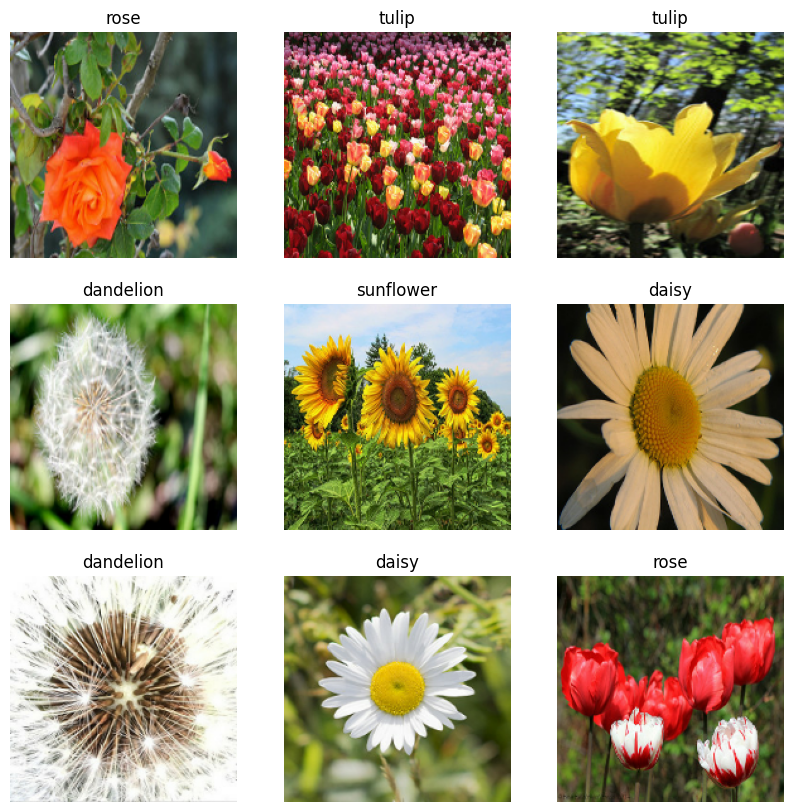

In [24]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [27]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Data Augmentation

In [28]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

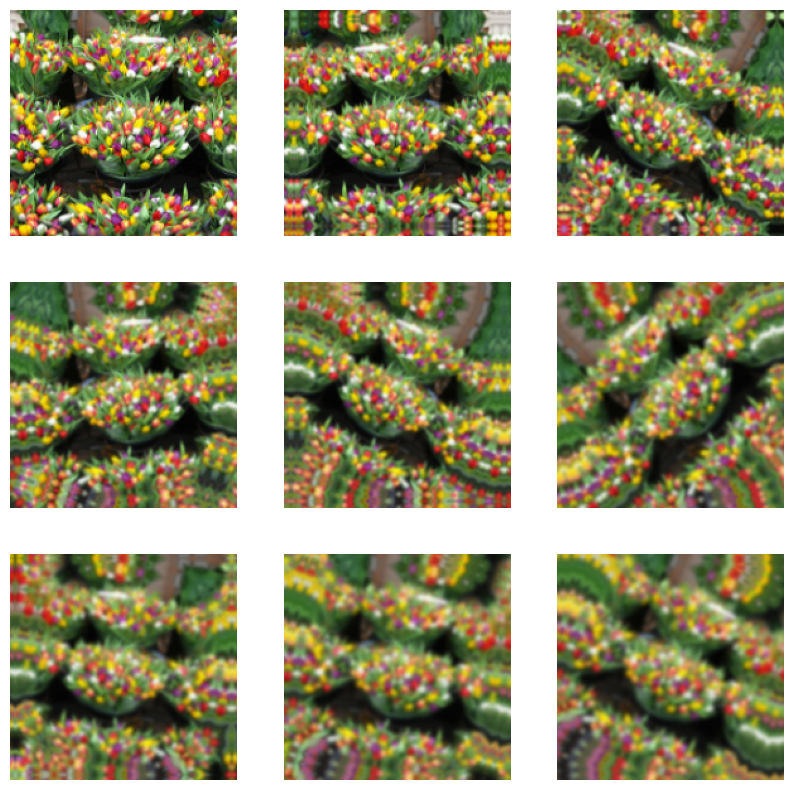

In [29]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

# Model Creation

In [33]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [36]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
108/108 [==============================] - 19s 171ms/step - loss: 1.3451 - accuracy: 0.4346 - val_loss: 1.1176 - val_accuracy: 0.5446
Epoch 2/15
108/108 [==============================] - 18s 167ms/step - loss: 1.0430 - accuracy: 0.5886 - val_loss: 1.0614 - val_accuracy: 0.5863
Epoch 3/15
108/108 [==============================] - 18s 168ms/step - loss: 0.9720 - accuracy: 0.6164 - val_loss: 0.9833 - val_accuracy: 0.6095
Epoch 4/15
108/108 [==============================] - 18s 167ms/step - loss: 0.8728 - accuracy: 0.6644 - val_loss: 1.0023 - val_accuracy: 0.6269
Epoch 5/15
108/108 [==============================] - 18s 167ms/step - loss: 0.8386 - accuracy: 0.6752 - val_loss: 0.8367 - val_accuracy: 0.6779
Epoch 6/15
108/108 [==============================] - 18s 168ms/step - loss: 0.8220 - accuracy: 0.6931 - val_loss: 0.8514 - val_accuracy: 0.6686
Epoch 7/15
108/108 [==============================] - 18s 168ms/step - loss: 0.7562 - accuracy: 0.7105 - val_loss: 0.8934 - val_ac

In [37]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [39]:
classify_images('../sample_images/daisy.jpg')

1/1 [==============================] - 0s 56ms/step


'The Image belongs to daisy with a score of 99.3885338306427'

In [40]:
model.save('../final_model/flower_recog_model.h5')

/Users/subhaarunpandian/anaconda3/envs/dl_env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
